# Informes y predicciones de COVID-19 en España 

Actualizado diariamente, este documento se [visualiza mejor aquí](https://nbviewer.jupyter.org/github/jaimevalero/COVID-19/blob/master/jupyter/Pain_Graphs.ipynb).

**Indice**

## [1. Datos de Madrid, hoy](#DatosMadrid)

## 2. Comparativas y predicciones

| Comparativas de dos dimensiones | Comparativas por comunidades  | Comparativas individuales | Predicciones |
| --- | --- | --- |  --- | 
| [Casos Vs fallecidos, historicos](#Comparativa_Casos_Fallecidos) | [Comparativa de fallecidos](#Comunidades_Fallecidos) | [Fallecidos hoy, en España](#Pico_España) | [Predicción de fallecidos, en España](#Prediccion_Fallecidos_España)|
| [Casos Vs fallecidos, hoy](#Comparativa_Casos_Fallecidos_Hoy) |   [Comparativa de fallecidos, hoy](#Comunidades_Fallecidos_Hoy) | [Fallecidos hoy, en Madrid](#Reporte_Fallecidos_hoy_absoluto_Madrid)|  [Predicción de fallecidos, en Madrid](#Prediccion_Fallecidos_hoy_absoluto_Madrid)
| [Casos Vs fallecidos, variación diaria](#Comparativa_Casos_Fallecidos_Variacion_Diaria) |[Comparativa de mortalidad](#Comunidades_Mortalidad)| [Fallecidos hoy, en Cataluña](#Reporte_Fallecidos_hoy_absoluto_Cataluña)|  [Predicción de fallecidos, en Cataluña](#Prediccion_Fallecidos_hoy_absoluto_Cataluña)
|  |  [Comparativa de curados](#Curados)| [Fallecidos hoy, en Castilla y León](#Reporte_Fallecidos_hoy_absoluto_CyL)|[Predicción de fallecidos, en Castilla y León](#Prediccion_Fallecidos_hoy_absoluto_CyL)
|  | | [Fallecidos hoy, en Castilla La Mancha](#Reporte_Fallecidos_hoy_absoluto_CM) |[Predicción de fallecidos, en Castilla La Mancha](#Prediccion_Fallecidos_hoy_absoluto_CM)
|  |  | | |
  



## [3. ¿ Son reales estos datos ?](#Reales)




In [1]:
# Cargamos datos
import Loading_data 
from matplotlib import pyplot as plt    
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML

def Insertar_Enlace(cell_name):
    display(HTML('<a id="'+ cell_name +'"></a>'))

Insertar_Enlace('DatosMadrid')

COMUNIDAD_A_CONSIDERAR = 'Madrid'
comunidad = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)
comunidad.head(10)




,Lugar,Casos,Casos hoy absoluto,Casos hoy variacion respecto ayer,Casos hoy porcentaje,Fallecidos,Fallecidos hoy absoluto,Fallecidos hoy variacion respecto ayer,Fallecidos hoy porcentaje,Tasa Mortalidad,Curados,Curados hoy absoluto,Casos excluidos curados,Proporcion Curados hoy absoluto / Casos hoy absoluto,UCI,Hospitalizados
Fecha,,,,,,,,,,,,,,,,
2020-05-15,Madrid,66005,312,-112,0.004727,8809,30,11,0.003406,0.133460,40383,184.0,25622,0.589744,3574,42057
2020-05-14,Madrid,65693,424,127,0.006454,8779,19,-21,0.002164,0.133637,40199,215.0,25494,0.507075,3564,41962
2020-05-13,Madrid,65269,297,178,0.004550,8760,40,3,0.004566,0.134214,39984,233.0,25285,0.784512,3555,41856
2020-05-12,Madrid,64972,119,53,0.001832,8720,37,-2,0.004243,0.134212,39751,147.0,25221,1.235294,3543,41735
2020-05-11,Madrid,64853,66,-198,0.001018,8683,39,-7,0.004492,0.133887,39604,75.0,25249,1.136364,3529,41650
2020-05-10,Madrid,64787,264,74,0.004075,8644,46,0,0.005322,0.133422,39529,302.0,25258,1.143939,3520,41559
2020-05-09,Madrid,64523,190,-273,0.002945,8598,46,-2,0.005350,0.133255,39227,252.0,25296,1.326316,3508,41436
2020-05-08,Madrid,64333,463,9,0.007197,8552,48,10,0.005613,0.132933,38975,305.0,25358,0.658747,3493,41304
2020-05-07,Madrid,63870,454,27,0.007108,8504,38,-8,0.004468,0.133145,38670,339.0,25200,0.746696,3485,41159


In [2]:
import pandas as pd


def Get_Dimensions_All_CCAA(Atributos,media_movil ):
    array = []
    dias_a_considerar = 4 if media_movil else 1
    for ca in COMUNIDADES: 
        
        comunidad = Loading_data.Get_Comunidad(ca).head(dias_a_considerar)
        comunidad = comunidad.reset_index() # Resets the index, makes factor a column
        if media_movil : comunidad = pd.DataFrame(comunidad.mean(axis=0)).T 
        temp_dict = {}
        temp_dict['Lugar'] = ca
        for attr in Atributos:
            temp_dict[attr] = comunidad[attr].iloc[0]
        array.append(temp_dict)

    return pd.DataFrame.from_records(array)



In [3]:
import scipy.stats as spstats
from matplotlib import pyplot as plt    


def Print_Two_Cordinates_CCAA(df, add_LR=False):
    fig,ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(8)
    ax.axhline(y=0, color='blue')
    ax.axvline(x=0, color='blue')

    for k,d in df.groupby('Lugar'):
        ax.scatter(d[df.columns[1]], d[df.columns[2]], label=k)

    plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    
    if add_LR:
        slope, intercept, r_value, p_value, std_err = spstats.linregress(df[df.columns[1]], df[df.columns[2]])
        plt.plot(df[df.columns[1]], intercept + slope*df[df.columns[1]], 'r', label='fitted line')
        #.format(round(slope, 2),round(intercept, 2),round(r_value, 2))
        note2add = f"""slope: {slope:12.4f}\nintercept: {intercept:8.2f}\nr2: {r_value**2:15.4f}"""
        plt.annotate(note2add,xy=(0.7,0.3), xycoords='figure fraction')
        
    ax.set_xlabel(df.columns[1])
    ax.set_ylabel(df.columns[2])
    ax.set_title(df.columns[1]+ ' VS. ' + df.columns[2])
    
    return plt


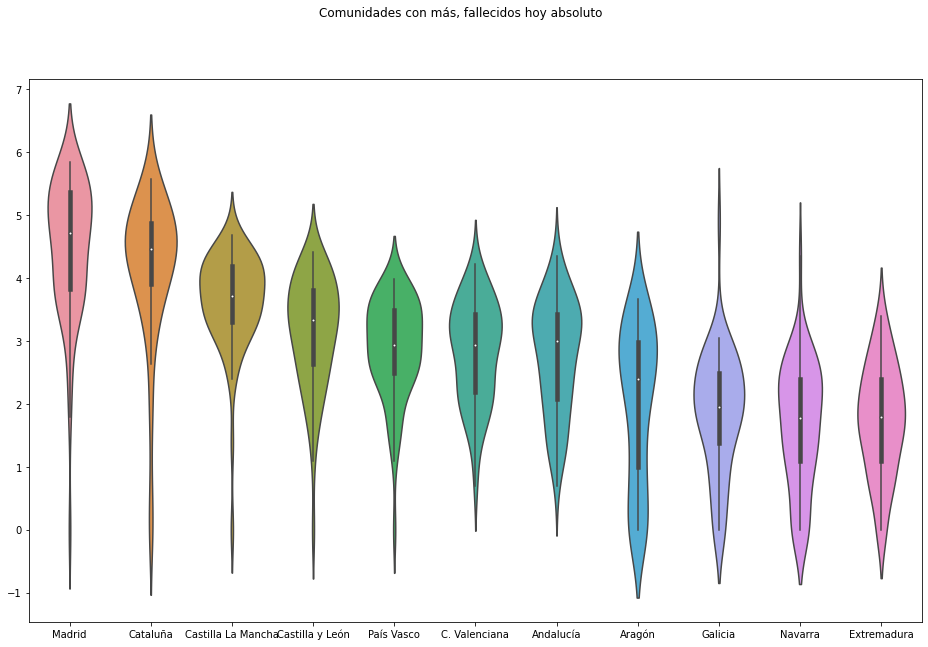

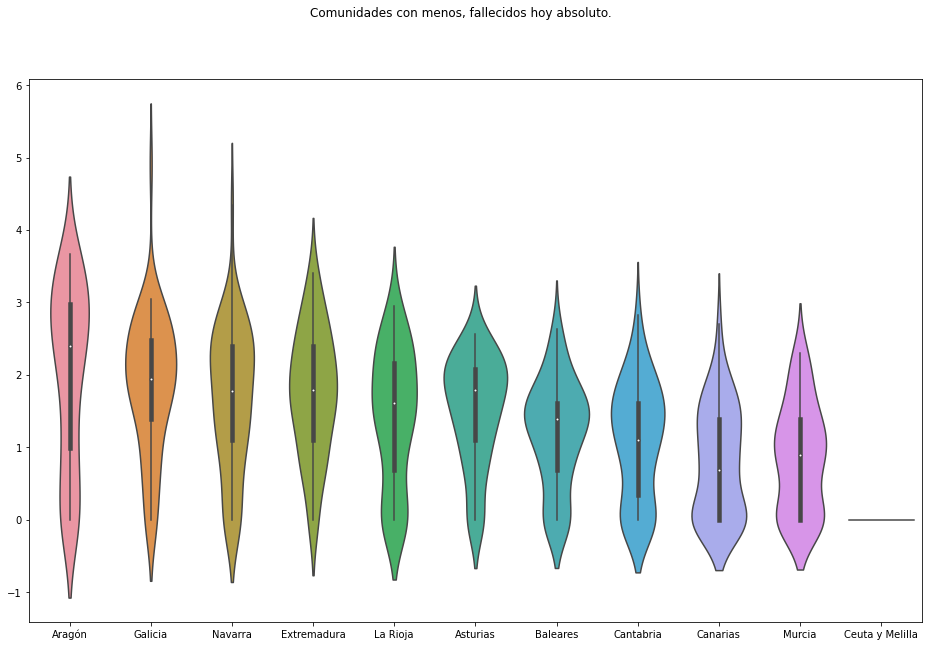

In [4]:
import numpy as np 
import seaborn as sns

from Loading_data import Get_Comunidades_List as comunidades
COMUNIDADES = comunidades()

def Get_Single_Dimension(dimension ):
    df = pd.DataFrame()
    df_tmp = pd.DataFrame()
    array = []
    #
    for ca in COMUNIDADES:
        df_tmp = Loading_data.Get_Comunidad(ca)
        new = df_tmp[[dimension]].copy()
        new.rename(columns={dimension: ca}, inplace=True)
        array.append(new)
    #
    df =  pd.concat(array, axis=1)
    return df

def plot_violin(dimension):
    """ Muestra la distribucion logaritmica por comunidades, de una dimension"""
    df = Get_Single_Dimension(dimension) 
    # Ordenamos comunidades 
    s = df.sum()
    df = df[s.sort_values(ascending=False).index[:]]

    # Pasamos a logaritmo
    df2 = np.log(df)
    df2.replace(-np.inf,  np.nan, inplace=True)
    display(HTML("<h2>Comparativa de distribucion de '" +dimension+ "', en cada CC.AA </h2>"))
    display(HTML("Distribuciones convertidas a logaritmos neperianos, para facilitar la comparación."))

    # primer grafico
    f, ax = plt.subplots()
    f.set_size_inches( 16, 10)
    f.suptitle("Comunidades con más, " + dimension.lower())
    sns.violinplot(data=df2.iloc[:,:-7])

    #segundo grafico
    f, ax = plt.subplots()
    f.set_size_inches( 16, 10)
    f.suptitle("Comunidades con menos, " + dimension.lower()+".")
    sns.violinplot(data=df2.iloc[:,7:])
    return df

dimension = 'Fallecidos hoy absoluto'
df = plot_violin(dimension)


In [5]:
df

,Madrid,Cataluña,Castilla La Mancha,Castilla y León,País Vasco,C. Valenciana,Andalucía,Aragón,Galicia,Navarra,Extremadura,La Rioja,Asturias,Baleares,Cantabria,Canarias,Murcia,Ceuta y Melilla
Fecha,,,,,,,,,,,,,,,,,,
2020-05-15,30,59,18,5,0,9,8,1,0,2,2,0,2,0,1,0,1,0
2020-05-14,19,131,17,6,12,8,4,7,4,4,3,0,1,1,0,0,0,0
2020-05-13,40,71,24,5,13,5,6,1,2,1,2,1,3,5,2,0,3,0
2020-05-12,37,66,25,9,6,6,4,3,2,3,4,1,5,1,2,2,0,0
2020-05-11,39,23,27,8,5,7,2,1,1,2,3,0,4,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-11,10,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
2020-03-10,13,2,0,0,1,0,0,2,0,0,0,1,0,0,0,0,0,0
2020-03-09,6,1,0,0,5,0,0,0,0,0,0,-1,0,0,0,0,0,0


In [6]:


import Loading_data 

from Loading_data import Get_Comunidades_List as comunidades
COMUNIDADES = comunidades()

def Comparar_Dos_Dimensiones(Atributos, media_movil=False, add_LR=False ):
    """ Compara dos dimensiones de atributos, Ma indica si hacerlo con la media movil"""
    
    df = Get_Dimensions_All_CCAA(Atributos,media_movil )
    df = df.sort_values(by=[df.columns[1],df.columns[2]])
    plt = Print_Two_Cordinates_CCAA(df, add_LR)
    plt.show()
    print(  'Total: '  + df.columns[1], df[df.columns[1]].sum() )
    print(  'Total: '  + df.columns[2], df[df.columns[2]].sum() )
    display(HTML(df.set_index('Lugar').to_html(index=True)))
    return 

  

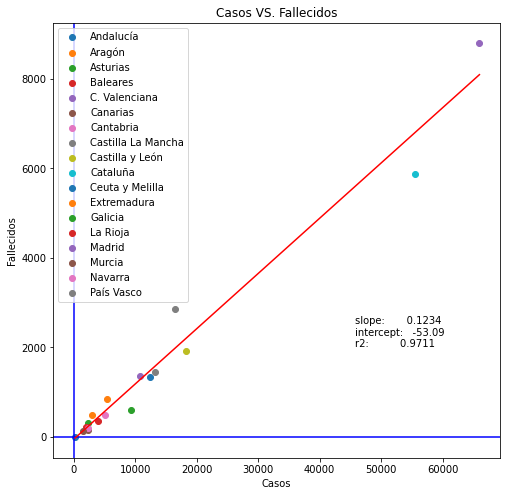

Total: Casos 230183
Total: Fallecidos 27459


,Casos,Fallecidos
Lugar,,
Ceuta y Melilla,235,6
Murcia,1534,143
Baleares,1967,216
Cantabria,2263,206
Canarias,2280,151
Asturias,2359,310
Extremadura,2933,494
La Rioja,4016,348
Navarra,5116,500


In [7]:
Insertar_Enlace("Comparativa_Casos_Fallecidos")
Comparar_Dos_Dimensiones(['Casos', 'Fallecidos'],add_LR=True )  


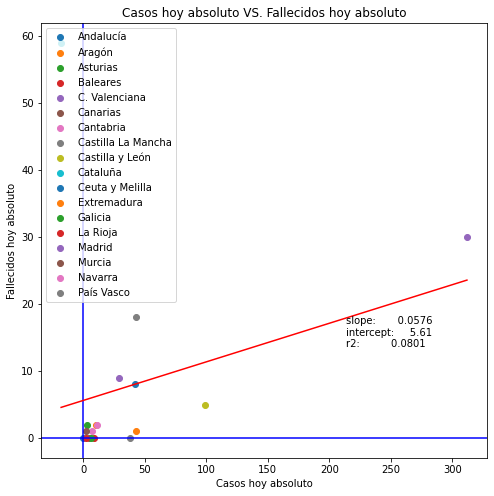

Total: Casos hoy absoluto 643
Total: Fallecidos hoy absoluto 138


,Casos hoy absoluto,Fallecidos hoy absoluto
Lugar,,
Cataluña,-18,59
Ceuta y Melilla,0,0
La Rioja,2,0
Murcia,2,1
Asturias,3,2
Canarias,5,0
Galicia,6,0
Cantabria,7,1
Baleares,9,0


In [8]:
Insertar_Enlace("Comparativa_Casos_Fallecidos_Hoy")

Comparar_Dos_Dimensiones(['Casos hoy absoluto', 'Fallecidos hoy absoluto'],add_LR=True )   

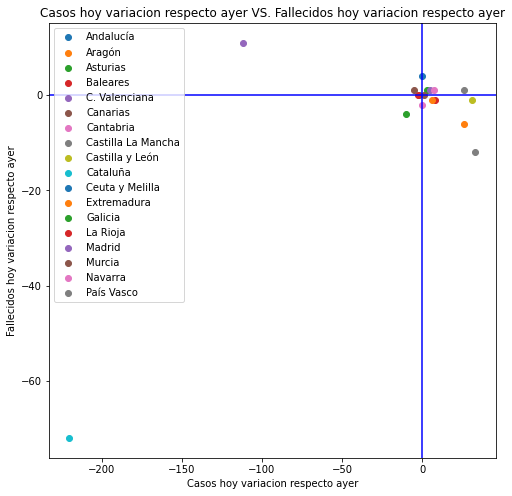

Total: Casos hoy variacion respecto ayer -206
Total: Fallecidos hoy variacion respecto ayer -79


,Casos hoy variacion respecto ayer,Fallecidos hoy variacion respecto ayer
Lugar,,
Cataluña,-220,-72
Madrid,-112,11
Galicia,-10,-4
Murcia,-5,1
La Rioja,-3,0
Ceuta y Melilla,-2,0
Navarra,0,-2
Andalucía,0,4
Canarias,1,0


In [9]:
Insertar_Enlace("Comparativa_Casos_Fallecidos_Variacion_Diaria")

Comparar_Dos_Dimensiones(['Casos hoy variacion respecto ayer', 'Fallecidos hoy variacion respecto ayer'])

In [10]:
# Cargamos datos
import pandas as pd
import Loading_data 

from Loading_data import Get_Comunidades_List as comunidades
COMUNIDADES = comunidades()

def Get_Dimension_CCAA(Dimension,include_nation=False):
    def Do_Stuff_to_DF(df):
        df = df.sort_values(by='Fecha')
        # df = df.reset_index() # Resets the index, makes factor a column    
        df = df[df["Casos"] >= 100]
        return df
        
    dimension_df = pd.DataFrame()
    for ca in COMUNIDADES: 
        df = Loading_data.Get_Comunidad(ca)
        df = Do_Stuff_to_DF(df)
        dimension_df[ca] = df[Dimension]
    if include_nation:
        df = Loading_data.Get_Nacion()
        df = Do_Stuff_to_DF(df)
        dimension_df['TOTAL'] = df[Dimension]
        
    return dimension_df 


In [11]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display, HTML
import pandas as pd

import numpy as np


def compare_charts_median(Dimension,df): 
    short_df = df.tail(1)
    short_df = short_df.T
    short_df = short_df.sort_values(by=(short_df.columns[0]))
    short_df.columns = [Dimension]

    #mean_y = short_df.median(axis=1)[0]
    #mean_y= df.tail(1).T.median().values[0]
    median_y= df.tail(1).T.drop(axis=0,labels=(['TOTAL'] if 'TOTAL' in short_df.index else [])).median().values[0]
    x = short_df.index
    y = short_df[Dimension]

    plt.figure(figsize = (10, 5))
    plt.scatter(x, y, c= "red", alpha = 0.5)
    plt.title(Dimension + " by region")
    color = 'blue'
    plt.xticks(rotation=90)
    plt.axhline(median_y, c = color, alpha = 0.5, lw = 1)
    plt.annotate('Median ' + Dimension+  ' is {}'.format(round(median_y, 2)),
            xy=(8.5, median_y),
            xycoords='data',
            xytext=(-50, 50), 
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color = "k", alpha = 0.5),
            color = color)
    return

def compare_charts_time(Dimension,df):
    fig = plt.figure(figsize=(8, 6), dpi=80)
    for ca in df.columns:
        plt.plot(df[ca])
    plt.legend(df.columns)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))

    fig.suptitle('Comparativa de: '+Dimension, fontsize=20)
    plt.show()
    return 

def Report_Location(Dimension,include_nation=False):
    # Ger Data
    df = Get_Dimension_CCAA(Dimension,include_nation)
    # Compare chart
    compare_charts_time(Dimension,df)
    # Compare median chart
    compare_charts_median(Dimension,df)
    
    with pd.option_context("display.max_rows", 1000):
        display(HTML(df.to_html()))
    return 

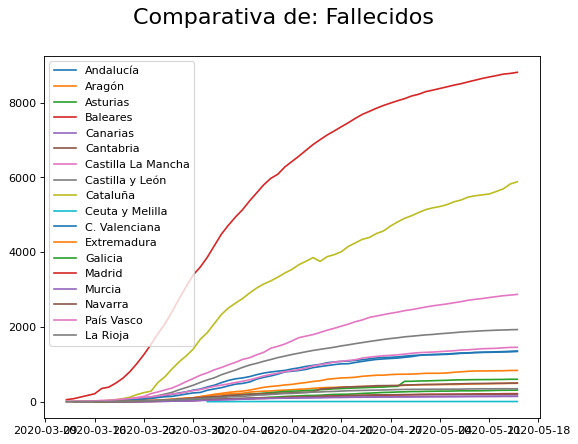

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
Fecha,,,,,,,,,,,,,,,,,,
2020-03-12,0,NaN,NaN,NaN,NaN,NaN,1,NaN,4,NaN,NaN,NaN,NaN,56,NaN,NaN,11,2
2020-03-13,0,NaN,NaN,NaN,NaN,NaN,5,1.0,4,NaN,NaN,NaN,NaN,81,NaN,0.0,14,2
2020-03-16,7,11.0,1.0,NaN,1.0,NaN,17,9.0,12,NaN,5.0,2.0,2.0,213,NaN,1.0,23,4
2020-03-17,11,12.0,1.0,NaN,2.0,NaN,17,12.0,18,NaN,13.0,3.0,3.0,355,NaN,2.0,36,5
2020-03-18,19,13.0,1.0,1.0,3.0,NaN,28,22.0,41,NaN,22.0,6.0,3.0,390,0.0,3.0,40,5
2020-03-19,23,15.0,1.0,2.0,3.0,NaN,42,29.0,55,NaN,24.0,8.0,4.0,498,0.0,4.0,53,5
2020-03-20,30,17.0,2.0,2.0,4.0,1.0,62,43.0,82,NaN,33.0,10.0,5.0,628,0.0,5.0,71,7
2020-03-21,40,22.0,5.0,4.0,7.0,2.0,84,55.0,122,NaN,50.0,12.0,9.0,804,1.0,9.0,85,15
2020-03-22,47,24.0,8.0,4.0,9.0,5.0,112,74.0,191,NaN,69.0,14.0,12.0,1021,1.0,14.0,97,18


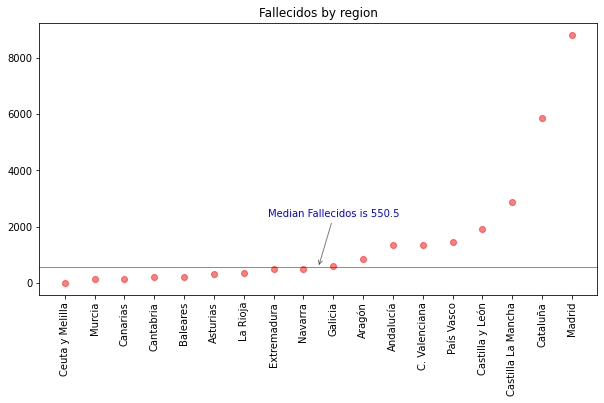

In [12]:
Insertar_Enlace("Comunidades_Fallecidos")
Report_Location("Fallecidos")

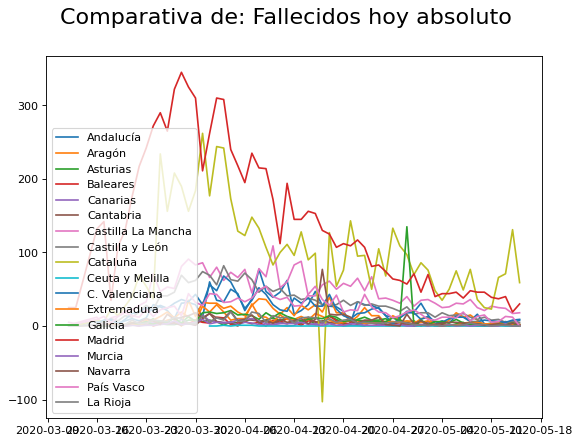

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
Fecha,,,,,,,,,,,,,,,,,,
2020-03-12,0,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,25,NaN,NaN,5,0
2020-03-13,0,NaN,NaN,NaN,NaN,NaN,4,1.0,0,NaN,NaN,NaN,NaN,25,NaN,0.0,3,0
2020-03-16,7,4.0,0.0,NaN,1.0,NaN,12,8.0,8,NaN,4.0,1.0,2.0,132,NaN,1.0,9,2
2020-03-17,4,1.0,0.0,NaN,1.0,NaN,0,3.0,6,NaN,8.0,1.0,1.0,142,NaN,1.0,13,1
2020-03-18,8,1.0,0.0,0.0,1.0,NaN,11,10.0,23,NaN,9.0,3.0,0.0,35,0.0,1.0,4,0
2020-03-19,4,2.0,0.0,1.0,0.0,NaN,14,7.0,14,NaN,2.0,2.0,1.0,108,0.0,1.0,13,0
2020-03-20,7,2.0,1.0,0.0,1.0,0.0,20,14.0,27,NaN,9.0,2.0,1.0,130,0.0,1.0,18,2
2020-03-21,10,5.0,3.0,2.0,3.0,1.0,22,12.0,40,NaN,17.0,2.0,4.0,176,1.0,4.0,14,8
2020-03-22,7,2.0,3.0,0.0,2.0,3.0,28,19.0,69,NaN,19.0,2.0,3.0,217,0.0,5.0,12,3


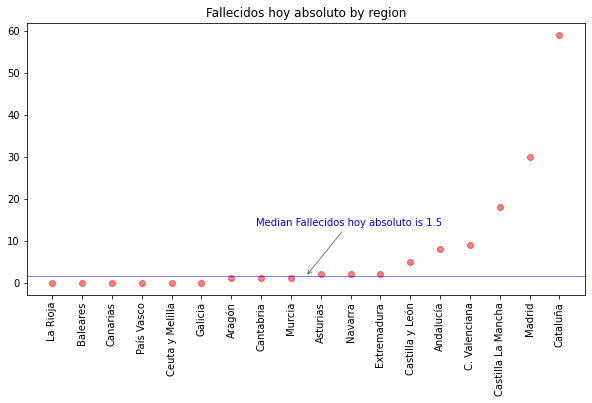

In [13]:
Insertar_Enlace("Comunidades_Fallecidos_Hoy")

Report_Location("Fallecidos hoy absoluto") 

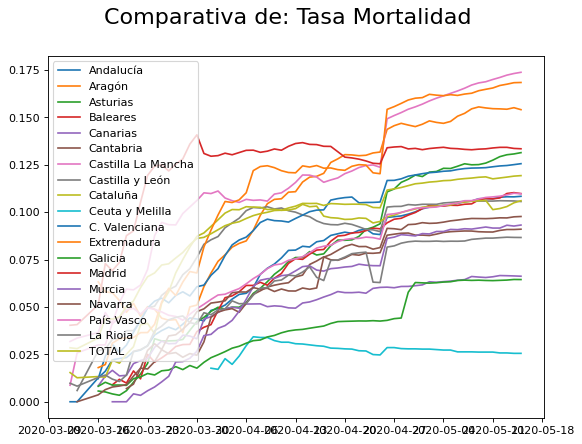

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja,TOTAL
Fecha,,,,,,,,,,,,,,,,,,,
2020-03-12,0.000000,NaN,NaN,NaN,NaN,NaN,0.008696,NaN,0.015385,NaN,NaN,NaN,NaN,0.040346,NaN,NaN,0.031792,0.009756,0.028475
2020-03-13,0.000000,NaN,NaN,NaN,NaN,NaN,0.025773,0.005917,0.012658,NaN,NaN,NaN,NaN,0.040704,NaN,0.000000,0.033573,0.008230,0.028035
2020-03-16,0.012635,0.063218,0.005650,NaN,0.008403,NaN,0.029982,0.026946,0.013289,NaN,0.012225,0.018018,0.008163,0.051140,NaN,0.003650,0.036508,0.012821,0.033620
2020-03-17,0.016105,0.057971,0.005181,NaN,0.013514,NaN,0.029982,0.027842,0.012912,NaN,0.024030,0.019608,0.010274,0.072880,NaN,0.006390,0.047059,0.014085,0.043926
2020-03-18,0.022119,0.057522,0.004132,0.008929,0.016575,NaN,0.041481,0.032934,0.021972,NaN,0.030303,0.030928,0.008798,0.069186,0.000000,0.007772,0.041110,0.011933,0.043599
2020-03-19,0.022817,0.053381,0.003425,0.011834,0.013636,NaN,0.052434,0.033410,0.020355,NaN,0.026059,0.033195,0.008830,0.073484,0.000000,0.008299,0.044538,0.010684,0.044731
2020-03-20,0.023310,0.047222,0.005814,0.009852,0.013937,0.006944,0.059387,0.037489,0.025076,NaN,0.029864,0.033670,0.008651,0.087648,0.000000,0.009025,0.048464,0.014085,0.050150
2020-03-21,0.026403,0.051887,0.010288,0.016260,0.020115,0.009302,0.059030,0.037517,0.029027,NaN,0.036684,0.033898,0.012179,0.090124,0.004167,0.013554,0.049275,0.026596,0.053197
2020-03-22,0.027246,0.045113,0.014679,0.012085,0.021739,0.017730,0.061572,0.042431,0.040604,NaN,0.043017,0.036458,0.013115,0.105236,0.003378,0.017632,0.046257,0.027523,0.060199


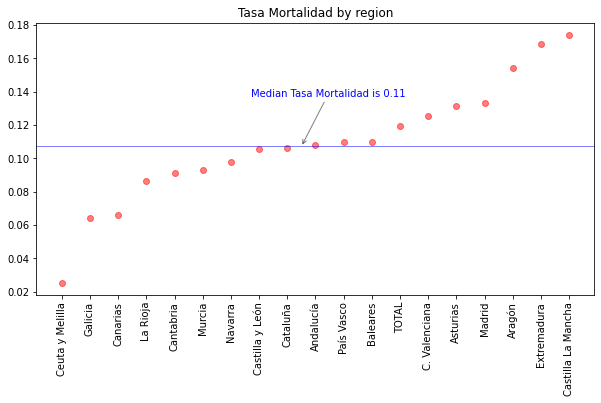

In [14]:
Insertar_Enlace("Comunidades_Mortalidad")

Report_Location("Tasa Mortalidad",True)

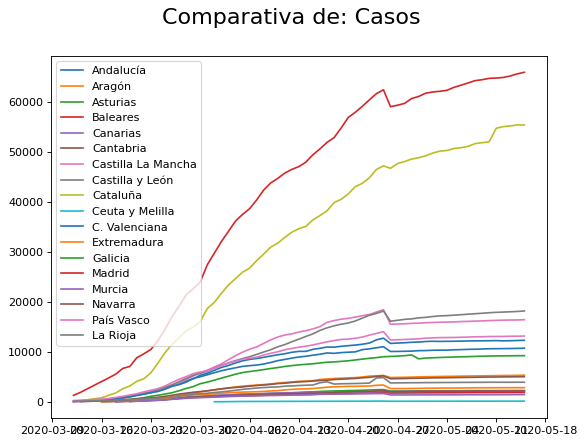

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
Fecha,,,,,,,,,,,,,,,,,,
2020-03-12,115,NaN,NaN,NaN,NaN,NaN,115,NaN,260,NaN,NaN,NaN,NaN,1388,NaN,NaN,346,205
2020-03-13,219,NaN,NaN,NaN,NaN,NaN,194,169.0,316,NaN,NaN,NaN,NaN,1990,NaN,130.0,417,243
2020-03-16,554,174.0,177.0,NaN,119.0,NaN,567,334.0,903,NaN,409.0,111.0,245.0,4165,NaN,274.0,630,312
2020-03-17,683,207.0,193.0,NaN,148.0,NaN,567,431.0,1394,NaN,541.0,153.0,292.0,4871,NaN,313.0,765,355
2020-03-18,859,226.0,242.0,112.0,181.0,NaN,675,668.0,1866,NaN,726.0,194.0,341.0,5637,122.0,386.0,973,419
2020-03-19,1008,281.0,292.0,169.0,220.0,NaN,801,868.0,2702,NaN,921.0,241.0,453.0,6777,167.0,482.0,1190,468
2020-03-20,1287,360.0,344.0,203.0,287.0,144.0,1044,1147.0,3270,NaN,1105.0,297.0,578.0,7165,204.0,554.0,1465,497
2020-03-21,1515,424.0,486.0,246.0,348.0,215.0,1423,1466.0,4203,NaN,1363.0,354.0,739.0,8921,240.0,664.0,1725,564
2020-03-22,1725,532.0,545.0,331.0,414.0,282.0,1819,1744.0,4704,NaN,1604.0,384.0,915.0,9702,296.0,794.0,2097,654


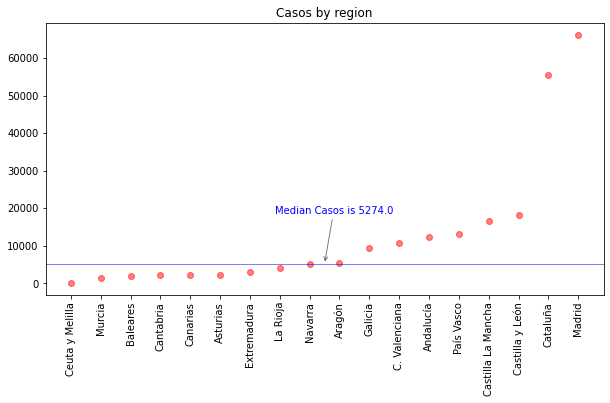

In [15]:
Insertar_Enlace("Comunidades_Casos")

Report_Location("Casos") 

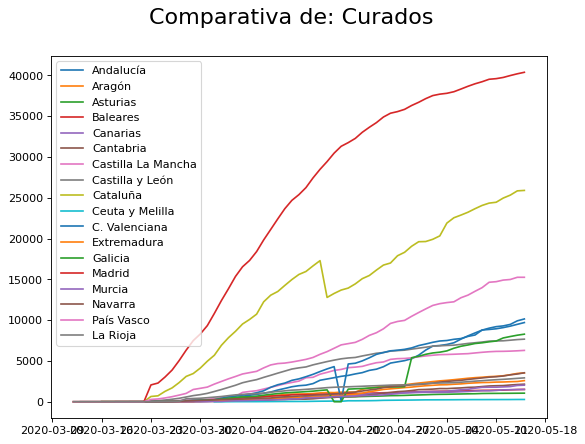

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
Fecha,,,,,,,,,,,,,,,,,,
2020-03-12,0,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0
2020-03-13,0,NaN,NaN,NaN,NaN,NaN,0,0.0,0,NaN,NaN,NaN,NaN,0,NaN,0.0,0,0
2020-03-16,0,0.0,0.0,NaN,0.0,NaN,0,0.0,0,NaN,0.0,0.0,0.0,0,NaN,0.0,0,0
2020-03-17,0,0.0,0.0,NaN,0.0,NaN,0,0.0,0,NaN,0.0,0.0,0.0,0,NaN,0.0,0,0
2020-03-18,0,0.0,0.0,0.0,0.0,NaN,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
2020-03-19,0,0.0,0.0,0.0,0.0,NaN,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
2020-03-20,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
2020-03-21,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
2020-03-22,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0


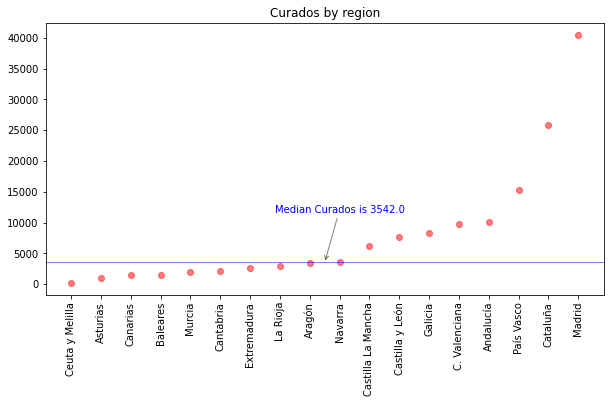

In [16]:
Insertar_Enlace("Curados")

Report_Location("Curados")

## ¿Hemos alcanzado el pico de la curva?


### Casos totales españa, evolucion


,Total Fallecidos,Total Fallecidos hoy absoluto,MA Total Fallecidos hoy absoluto,Variacion MA Total Fallecidos hoy absoluto
Fecha,,,,
2020-03-12,74,NaN,NaN,NaN
2020-03-13,107,33.0,NaN,NaN
2020-03-16,308,201.0,NaN,NaN
2020-03-17,490,182.0,NaN,NaN
2020-03-18,597,107.0,130.75,NaN
...,...,...,...,...
2020-05-11,26744,123.0,168.50,-22.50
2020-05-12,26920,176.0,155.25,-13.25
2020-05-13,27104,184.0,156.50,1.25


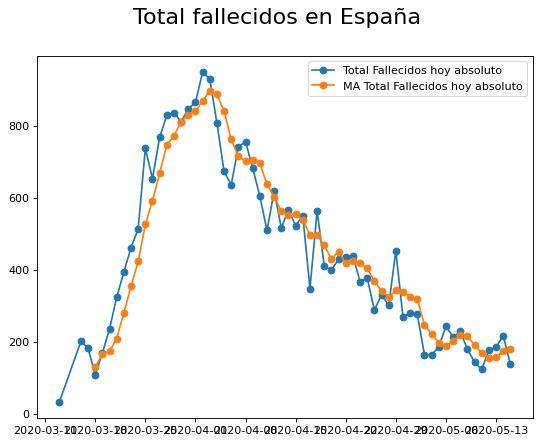

In [17]:
# Casos totales españa, evolucion
import Loading_data 

MOVING_AVERAGE_WINDOW=4

def get_fallecidos_nacion(window_size=MOVING_AVERAGE_WINDOW):
    Dimension = 'Fallecidos'
    
    Insertar_Enlace("Pico_España")

    df = Get_Dimension_CCAA(Dimension)

    df['Total Fallecidos'] = df.sum(axis=1)
    df['Total Fallecidos']

    CONVERT_INT_COLUMNS = ['Total Fallecidos']
    for column in CONVERT_INT_COLUMNS :
        df[column] = df[column].fillna(0)
        df[column] = df[column].astype(np.int64)

    df['Total Fallecidos hoy absoluto'] = df['Total Fallecidos'] - df['Total Fallecidos'].shift(1)
    df['MA Total Fallecidos hoy absoluto'] = df['Total Fallecidos hoy absoluto'].rolling(window=window_size).mean()

    df['Variacion MA Total Fallecidos hoy absoluto'] = df['MA Total Fallecidos hoy absoluto'] - df['MA Total Fallecidos hoy absoluto'].shift(1)
    return df

df = get_fallecidos_nacion()
df_plt = df[['Total Fallecidos hoy absoluto','MA Total Fallecidos hoy absoluto']]
fig = plt.figure(figsize=(8, 6), dpi=80)
plt.plot(df_plt, marker='o') 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.legend(df_plt.columns)
fig.suptitle( "Total fallecidos en España", fontsize=20)

df[['Total Fallecidos',
    'Total Fallecidos hoy absoluto',
    'MA Total Fallecidos hoy absoluto',
    'Variacion MA Total Fallecidos hoy absoluto']]



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-03-16,126.875368,15.381017,162.774622,126.875368,126.875368,-34.697492,-34.697492,-34.697492,-34.697492,-34.697492,-34.697492,0.0,0.0,0.0,92.177876
2,2020-03-17,178.534139,94.797124,260.590547,178.534139,178.534139,-0.694033,-0.694033,-0.694033,-0.694033,-0.694033,-0.694033,0.0,0.0,0.0,177.840107
3,2020-03-18,230.192911,191.932419,343.678333,230.192911,230.192911,39.863766,39.863766,39.863766,39.863766,39.863766,39.863766,0.0,0.0,0.0,270.056677
4,2020-03-19,281.851683,228.157656,381.793048,281.851683,281.851683,23.168646,23.168646,23.168646,23.168646,23.168646,23.168646,0.0,0.0,0.0,305.020328
5,2020-03-20,333.510454,260.379414,418.090560,333.510454,333.510454,4.048747,4.048747,4.048747,4.048747,4.048747,4.048747,0.0,0.0,0.0,337.559201
6,2020-03-21,385.169226,308.575396,470.146869,385.169226,385.169226,5.680910,5.680910,5.680910,5.680910,5.680910,5.680910,0.0,0.0,0.0,390.850136
7,2020-03-22,436.827998,320.060053,478.291254,436.827998,436.827998,-37.370544,-37.370544,-37.370544,-37.370544,-37.370544,-37.370544,0.0,0.0,0.0,399.457453
8,2020-03-23,488.486769,373.940338,535.888675,488.486769,488.486769,-34.697492,-34.697492,-34.697492,-34.697492,-34.697492,-34.697492,0.0,0.0,0.0,453.789277
9,2020-03-24,540.145541,462.245523,614.883441,540.145541,540.145541,-0.694033,-0.694033,-0.694033,-0.694033,-0.694033,-0.694033,0.0,0.0,0.0,539.451508
10,2020-03-25,591.804313,548.949125,712.851836,591.804313,591.804313,39.863766,39.863766,39.863766,39.863766,39.863766,39.863766,0.0,0.0,0.0,631.668078


Prediccion total para Total Fallecidos hoy absoluto : 27711.236956947858


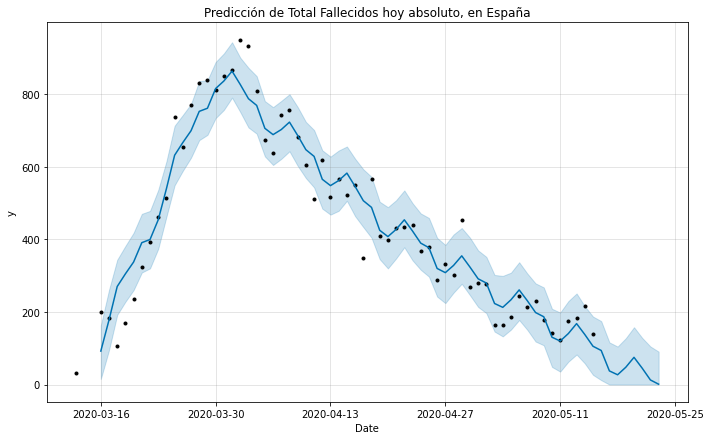

In [18]:
import fbprophet
def Get_Prediction_Nacion(df,dimension,location='España' , link=None) :
    df = df[[dimension]]
    df = df[df[dimension] > 0]

    df = df.dropna()
    df = df.reset_index()
    df.columns = ['ds','y']


    df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
    df_prophet.fit(df)

    # Make a future dataframe for 2 years
    df_forecast = df_prophet.make_future_dataframe(periods=45, freq='D')
    # Make predictions
    df_forecast = df_prophet.predict(df_forecast)
    df_forecast

    df_forecast = df_forecast[df_forecast["yhat"] >= 0]
    df_forecast.loc[df_forecast.yhat_lower < 0, 'yhat_lower'] = 0
    
    if link is not None:
        Insertar_Enlace(link)

    df_prophet.plot(df_forecast, xlabel = 'Date' )
    plt.title('Predicción de ' + dimension + ", en " + location )

    suma = df_forecast.trend.sum()
    display(HTML(pd.DataFrame(df_forecast).to_html()))

    print ("Prediccion total para " + dimension + " : " + str(suma) )
    return df_forecast
    
    
Insertar_Enlace("Prediccion_Fallecidos_España")
    
prediccion = Get_Prediction_Nacion( df = get_fallecidos_nacion(), 
                                   dimension = 'Total Fallecidos hoy absoluto')

In [19]:
def Get_Predictions_Compare(df,dimension,location='España' , link=None) :
    if link is not None:
        Insertar_Enlace(link)


    display(HTML("<h2>Comparativa de predicciones, hoy contra días pasados, " +dimension+ " en " +  location+ "</h2>"))

        
    df = df[[dimension]]
    df = df[df[dimension] > 0]

    df = df.dropna()
    df = df.reset_index()

    df.columns = ['ds','y']
    
    df_original = df.copy()

    
    results = pd.DataFrame()
    array_results_temp = []
    for i in range(4):
        
        if i >= 1 : df = df.iloc[1:]
    
        fecha=max(df.ds)
        fecha_short = str(fecha)[:10]
        

        df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
        df_prophet.fit(df)

        # Make a future dataframe 
        df_forecast = df_prophet.make_future_dataframe(periods=45, freq='D')
        # Make predictions
        df_forecast = df_prophet.predict(df_forecast)
        suma = df_forecast.yhat.sum()
            
        title_column = "Predicción con los datos de " + fecha_short
        df_forecast[title_column] = df_forecast.yhat
        
        array_results_temp.append(pd.DataFrame(df_forecast[['ds',title_column]]))


    df_1 = pd.merge(array_results_temp[0], array_results_temp[1], how ='outer', on ='ds') 
    df_2 = pd.merge(df_1                 , array_results_temp[2], how ='outer', on ='ds') 
    df_3 = pd.merge(df_2                 , array_results_temp[3], how ='outer', on ='ds') 
    df_4 = pd.merge(df_3                 , df_original          , how ='outer', on ='ds') 
    df_4['datos reales'] = df_4['y']
    del df_4['y']

        
    df_chart = df_4
    df_chart = df_chart.set_index('ds')
    df_chart = df_chart.head(70).tail(40)

    for c in df_chart.columns: 
        df_chart.loc[df_chart[c] < 0, c] = 0

    df_chart.drop(df_chart.loc[df_chart.sum(axis=1)==0].index, inplace=True)
    df_chart.drop(columns=df_chart.columns[df_chart.sum()==0], inplace=True)


    fig = plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(df_chart) 
    plt.title("Predicciones en días anteriores Vs. Datos reales" + dimension +", en " + location )
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.xticks(rotation=90)
    plt.legend(df_chart.columns)



    #print(df_chart)

    print("Las predicciones del total de "+ dimension+  " en " +  location+  ", cambian dia a dia")
    print(df_chart.sum(axis=0) )

    return df_chart



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Las predicciones del total de Fallecidos hoy absoluto en España, cambian dia a dia
Predicción con los datos de 2020-05-15    10479.976615
Predicción con los datos de 2020-05-14    10377.582700
Predicción con los datos de 2020-05-13    10127.559790
Predicción con los datos de 2020-05-12    10023.023314
datos reales                               9970.000000
dtype: float64


,Predicción con los datos de 2020-05-15,Predicción con los datos de 2020-05-14,Predicción con los datos de 2020-05-13,Predicción con los datos de 2020-05-12,datos reales
ds,,,,,
2020-04-14,561.889391,563.738065,566.579443,567.153668,567.0
2020-04-15,582.383714,584.763114,587.800921,583.866328,523.0
2020-04-16,545.627238,548.414573,539.470026,539.403969,551.0
2020-04-17,506.445983,505.060009,507.038302,507.110310,348.0
2020-04-18,488.024414,490.623220,492.906790,493.123253,565.0
2020-04-19,424.919227,427.763525,430.379007,430.739326,410.0
2020-04-20,407.551489,410.514703,413.350600,417.848336,399.0
2020-04-21,427.363139,429.164469,433.080448,437.523521,430.0
2020-04-22,453.729127,454.369688,459.365114,458.859851,435.0


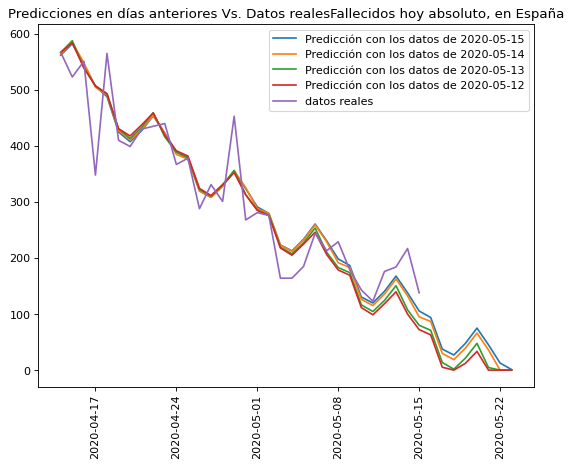

In [20]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'España'

link="Prediccion_Fallecidos_hoy_absoluto_España"


df = get_fallecidos_nacion()[['Total Fallecidos hoy absoluto']] 
df.columns = [ 'Fallecidos hoy absoluto' ]
df.sort_index(inplace=True,ascending=False)

prediccion = Get_Predictions_Compare( df = df, 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR
                                   )
prediccion

In [21]:
MOVING_AVERAGE_WINDOW = 4
def report_single_location_single_dimension(location,dimension,window_size=MOVING_AVERAGE_WINDOW):
    
    Dimension = 'Fallecidos'
    labelMa = f'Moving Average ({window_size}) {dimension}'

    df = pd.DataFrame()
    df[dimension] = Get_Dimension_CCAA(dimension)[location]
    df[labelMa] = df[dimension].rolling(window=window_size).mean()

    display(HTML("<h2>Analisis de ''" + dimension +"'', en " + location + "</h2>"))
    fig = plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(df, marker='o') 
    plt.title("Gráfico de " + dimension +", en " + location)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))


    plt.legend(df.columns)
    fig.suptitle( dimension + ' in ' + location, fontsize=20)

    display(HTML(pd.DataFrame(df).to_html()))
    return  


### Casos totales españa, evolucion


,Fallecidos hoy absoluto,Moving Average (4) Fallecidos hoy absoluto
Fecha,,
2020-03-12,25,NaN
2020-03-13,25,NaN
2020-03-16,132,NaN
2020-03-17,142,81.00
2020-03-18,35,83.50
2020-03-19,108,104.25
2020-03-20,130,103.75
2020-03-21,176,112.25
2020-03-22,217,157.75


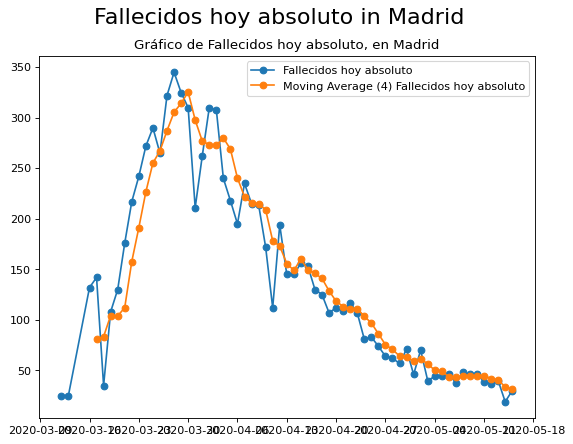

In [22]:

dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Madrid'

Insertar_Enlace("Reporte_Fallecidos_hoy_absoluto_Madrid")

report_single_location_single_dimension(COMUNIDAD_A_CONSIDERAR,dimension,4)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-03-09,2.167655,0.000000,40.766896,2.167655,2.167655,1.047605,1.047605,1.047605,1.047605,1.047605,1.047605,0.0,0.0,0.0,3.215260
2,2020-03-10,17.500321,0.000000,54.848952,17.500321,17.500321,-1.476113,-1.476113,-1.476113,-1.476113,-1.476113,-1.476113,0.0,0.0,0.0,16.024207
3,2020-03-11,32.832987,0.000000,63.904053,32.832987,32.832987,-6.300134,-6.300134,-6.300134,-6.300134,-6.300134,-6.300134,0.0,0.0,0.0,26.532853
4,2020-03-12,48.165653,14.023415,86.844728,48.165653,48.165653,1.275939,1.275939,1.275939,1.275939,1.275939,1.275939,0.0,0.0,0.0,49.441592
5,2020-03-13,63.498319,26.626865,102.842767,63.498319,63.498319,3.031387,3.031387,3.031387,3.031387,3.031387,3.031387,0.0,0.0,0.0,66.529705
6,2020-03-16,109.496316,71.539934,148.453544,109.496316,109.496316,1.047605,1.047605,1.047605,1.047605,1.047605,1.047605,0.0,0.0,0.0,110.543922
7,2020-03-17,124.828982,85.115258,158.836468,124.828982,124.828982,-1.476113,-1.476113,-1.476113,-1.476113,-1.476113,-1.476113,0.0,0.0,0.0,123.352869
8,2020-03-18,140.161648,97.200876,172.679500,140.161648,140.161648,-6.300134,-6.300134,-6.300134,-6.300134,-6.300134,-6.300134,0.0,0.0,0.0,133.861514
9,2020-03-19,155.494314,121.545603,192.700668,155.494314,155.494314,1.275939,1.275939,1.275939,1.275939,1.275939,1.275939,0.0,0.0,0.0,156.770253
10,2020-03-20,170.826980,138.570668,212.691198,170.826980,170.826980,3.031387,3.031387,3.031387,3.031387,3.031387,3.031387,0.0,0.0,0.0,173.858367


Prediccion total para Fallecidos hoy absoluto : 8870.941189823885


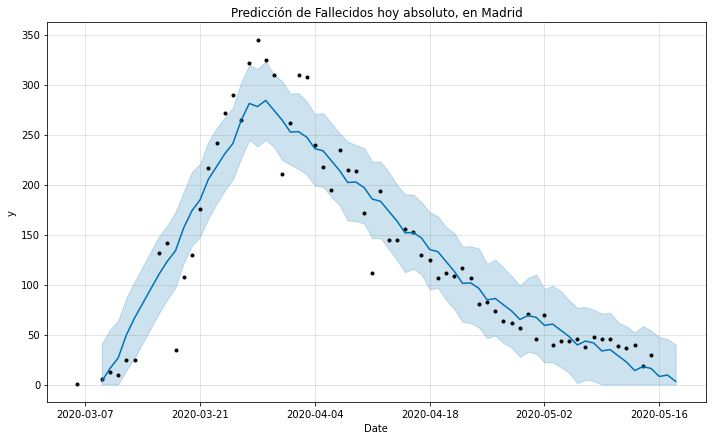

In [23]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Madrid'

link="Prediccion_Fallecidos_hoy_absoluto_Madrid"

prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR
                                   )
                                 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Las predicciones del total de Fallecidos hoy absoluto en Madrid, cambian dia a dia
Predicción con los datos de 2020-05-15    3420.083028
Predicción con los datos de 2020-05-14    3402.222683
Predicción con los datos de 2020-05-13    3376.973705
Predicción con los datos de 2020-05-12    3320.335349
datos reales                              3223.000000
dtype: float64


,Predicción con los datos de 2020-05-15,Predicción con los datos de 2020-05-14,Predicción con los datos de 2020-05-13,Predicción con los datos de 2020-05-12,datos reales
ds,,,,,
2020-04-09,202.511347,204.188380,203.601233,204.019940,214.0
2020-04-10,197.059798,197.074564,196.711136,196.925623,172.0
2020-04-11,185.528912,185.529210,184.730848,185.299090,112.0
2020-04-12,183.328234,184.823249,183.639832,184.418513,194.0
2020-04-13,173.455251,174.843333,173.770910,174.562226,145.0
2020-04-14,163.724762,165.171527,164.105827,165.080307,145.0
2020-04-15,151.694659,153.200806,152.141012,149.464679,156.0
2020-04-16,152.064650,153.629891,152.158924,152.804705,153.0
2020-04-17,146.615423,146.577231,145.269972,145.713902,130.0


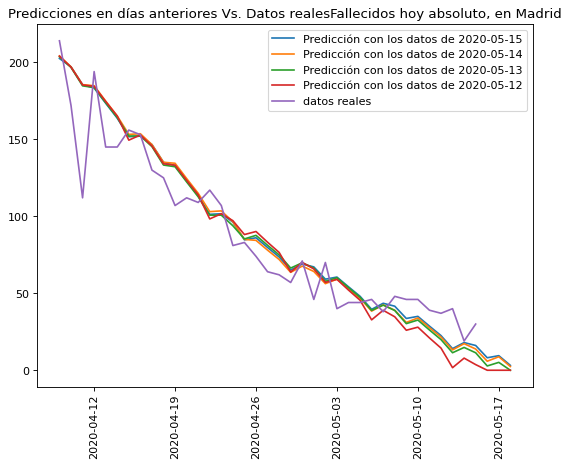

In [24]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Madrid'
link="Prediccion_Compare_Fallecidos_hoy_absoluto_Madrid"

df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)
prediccion = Get_Predictions_Compare( df = df, 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR
                                   )
prediccion

,Fallecidos hoy absoluto,Moving Average (4) Fallecidos hoy absoluto
Fecha,,
2020-03-12,1,NaN
2020-03-13,0,NaN
2020-03-16,8,NaN
2020-03-17,6,3.75
2020-03-18,23,9.25
2020-03-19,14,12.75
2020-03-20,27,17.50
2020-03-21,40,26.00
2020-03-22,69,37.50


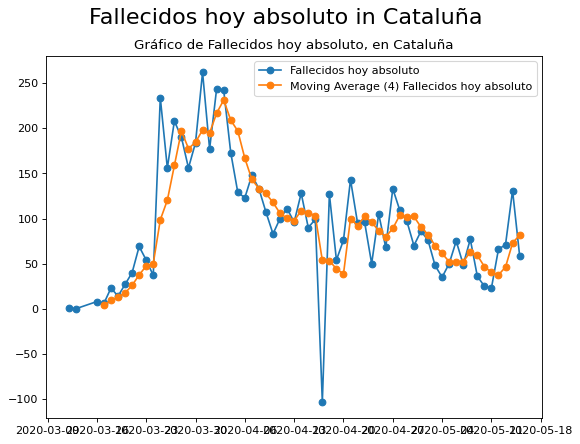

In [25]:

dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Cataluña'

Insertar_Enlace("Reporte_Fallecidos_hoy_absoluto_Cataluña")

report_single_location_single_dimension(COMUNIDAD_A_CONSIDERAR,dimension)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-03-10,-2.139213,0.000000,54.836183,-2.139213,-2.139213,6.583362,6.583362,6.583362,6.583362,6.583362,6.583362,0.0,0.0,0.0,4.444149
2,2020-03-12,13.072319,0.000000,70.999906,13.072319,13.072319,7.154975,7.154975,7.154975,7.154975,7.154975,7.154975,0.0,0.0,0.0,20.227294
3,2020-03-16,43.495381,0.000000,79.735462,43.495381,43.495381,-13.690458,-13.690458,-13.690458,-13.690458,-13.690458,-13.690458,0.0,0.0,0.0,29.804923
4,2020-03-17,51.101147,9.022095,111.014195,51.101147,51.101147,6.583362,6.583362,6.583362,6.583362,6.583362,6.583362,0.0,0.0,0.0,57.684509
5,2020-03-18,58.706913,18.616329,119.931013,58.706913,58.706913,12.241632,12.241632,12.241632,12.241632,12.241632,12.241632,0.0,0.0,0.0,70.948544
6,2020-03-19,66.312678,24.115870,124.366980,66.312678,66.312678,7.154975,7.154975,7.154975,7.154975,7.154975,7.154975,0.0,0.0,0.0,73.467654
7,2020-03-20,73.918444,30.513367,131.457559,73.918444,73.918444,8.346287,8.346287,8.346287,8.346287,8.346287,8.346287,0.0,0.0,0.0,82.264731
8,2020-03-21,81.524210,30.812846,128.999571,81.524210,81.524210,1.372878,1.372878,1.372878,1.372878,1.372878,1.372878,0.0,0.0,0.0,82.897088
9,2020-03-22,89.129976,18.011047,120.412815,89.129976,89.129976,-22.008677,-22.008677,-22.008677,-22.008677,-22.008677,-22.008677,0.0,0.0,0.0,67.121299
10,2020-03-23,96.735741,34.466189,135.091241,96.735741,96.735741,-13.690458,-13.690458,-13.690458,-13.690458,-13.690458,-13.690458,0.0,0.0,0.0,83.045283


Prediccion total para Fallecidos hoy absoluto : 6306.81530539701


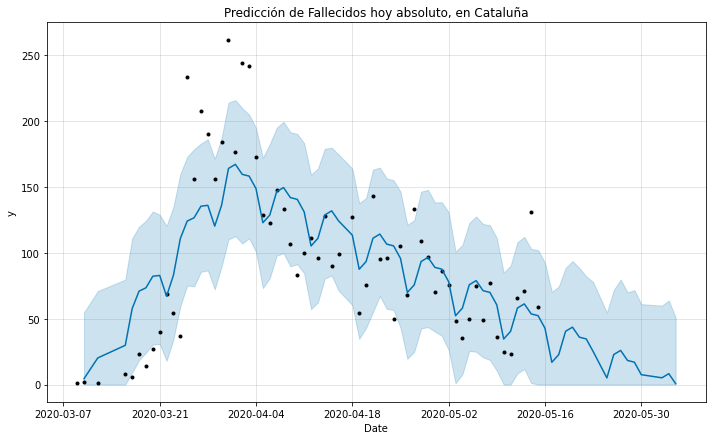

In [26]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Cataluña'
link="Prediccion_Fallecidos_hoy_absoluto_Cataluña"


prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR)
                                 

,Fallecidos hoy absoluto,Moving Average (4) Fallecidos hoy absoluto
Fecha,,
2020-03-12,NaN,NaN
2020-03-13,1.0,NaN
2020-03-16,8.0,NaN
2020-03-17,3.0,NaN
2020-03-18,10.0,5.50
2020-03-19,7.0,7.00
2020-03-20,14.0,8.50
2020-03-21,12.0,10.75
2020-03-22,19.0,13.00


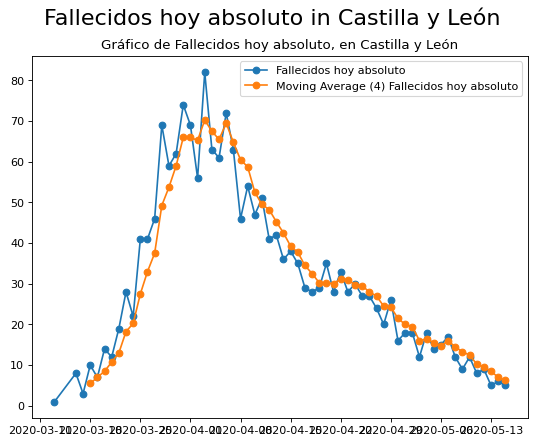

In [27]:
dimension = 'Fallecidos hoy absoluto'
report_single_location_single_dimension('Castilla y León',dimension)

Insertar_Enlace("Reporte_Fallecidos_hoy_absoluto_CyL")


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-03-16,2.336784,0.000000,11.960962,2.336784,2.336784,2.481503,2.481503,2.481503,2.481503,2.481503,2.481503,0.0,0.0,0.0,4.818287
2,2020-03-17,6.375080,0.000000,12.925543,6.375080,6.375080,-1.020852,-1.020852,-1.020852,-1.020852,-1.020852,-1.020852,0.0,0.0,0.0,5.354228
3,2020-03-18,10.413376,2.877828,17.841430,10.413376,10.413376,0.143454,0.143454,0.143454,0.143454,0.143454,0.143454,0.0,0.0,0.0,10.556830
4,2020-03-19,14.451672,4.990769,19.633381,14.451672,14.451672,-2.143393,-2.143393,-2.143393,-2.143393,-2.143393,-2.143393,0.0,0.0,0.0,12.308279
5,2020-03-20,18.489969,12.636024,27.622315,18.489969,18.489969,1.690507,1.690507,1.690507,1.690507,1.690507,1.690507,0.0,0.0,0.0,20.180476
6,2020-03-21,22.528265,15.873917,30.340941,22.528265,22.528265,0.454543,0.454543,0.454543,0.454543,0.454543,0.454543,0.0,0.0,0.0,22.982807
7,2020-03-22,26.566561,17.965557,32.756792,26.566561,26.566561,-1.605762,-1.605762,-1.605762,-1.605762,-1.605762,-1.605762,0.0,0.0,0.0,24.960799
8,2020-03-23,30.604857,25.498700,40.506463,30.604857,30.604857,2.481503,2.481503,2.481503,2.481503,2.481503,2.481503,0.0,0.0,0.0,33.086360
9,2020-03-24,34.643153,26.018221,40.822067,34.643153,34.643153,-1.020852,-1.020852,-1.020852,-1.020852,-1.020852,-1.020852,0.0,0.0,0.0,33.622302
10,2020-03-25,38.681450,31.774294,46.150241,38.681450,38.681450,0.143454,0.143454,0.143454,0.143454,0.143454,0.143454,0.0,0.0,0.0,38.824904


Prediccion total para Fallecidos hoy absoluto : 1938.1548885447717


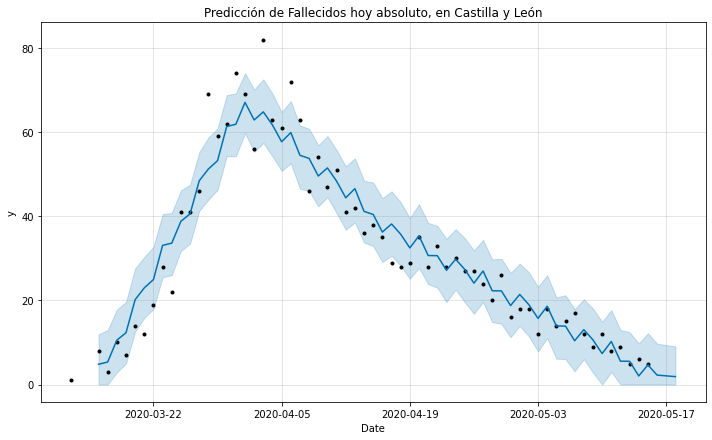

In [28]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Castilla y León'
link="Prediccion_Fallecidos_hoy_absoluto_CyL"

prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension , 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR )
                                 
                                 

,Fallecidos hoy absoluto,Moving Average (4) Fallecidos hoy absoluto
Fecha,,
2020-03-12,1,NaN
2020-03-13,4,NaN
2020-03-16,12,NaN
2020-03-17,0,4.25
2020-03-18,11,6.75
2020-03-19,14,9.25
2020-03-20,20,11.25
2020-03-21,22,16.75
2020-03-22,28,21.00


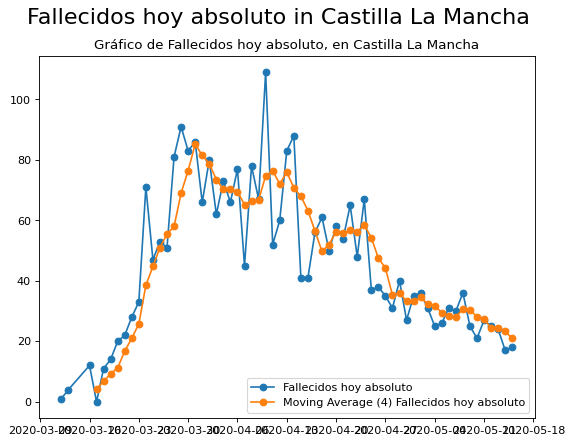

In [29]:
dimension = 'Fallecidos hoy absoluto'
report_single_location_single_dimension('Castilla La Mancha',dimension)
Insertar_Enlace("Reporte_Fallecidos_hoy_absoluto_CM")


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-03-13,3.431108,0.000000,22.565647,3.431108,3.431108,3.761810,3.761810,3.761810,3.761810,3.761810,3.761810,0.0,0.0,0.0,7.192917
2,2020-03-16,15.374806,1.991534,31.715651,15.374806,15.374806,1.820087,1.820087,1.820087,1.820087,1.820087,1.820087,0.0,0.0,0.0,17.194894
3,2020-03-18,23.337272,6.405437,37.382867,23.337272,23.337272,-1.602008,-1.602008,-1.602008,-1.602008,-1.602008,-1.602008,0.0,0.0,0.0,21.735264
4,2020-03-19,27.318505,7.795789,37.870315,27.318505,27.318505,-3.926448,-3.926448,-3.926448,-3.926448,-3.926448,-3.926448,0.0,0.0,0.0,23.392058
5,2020-03-20,31.299738,20.575966,49.418913,31.299738,31.299738,3.761810,3.761810,3.761810,3.761810,3.761810,3.761810,0.0,0.0,0.0,35.061548
6,2020-03-21,35.280971,19.568294,49.330261,35.280971,35.280971,-1.636810,-1.636810,-1.636810,-1.636810,-1.636810,-1.636810,0.0,0.0,0.0,33.644161
7,2020-03-22,39.262204,23.965122,52.229264,39.262204,39.262204,-1.958754,-1.958754,-1.958754,-1.958754,-1.958754,-1.958754,0.0,0.0,0.0,37.303450
8,2020-03-23,43.243437,30.569727,59.315577,43.243437,43.243437,1.820087,1.820087,1.820087,1.820087,1.820087,1.820087,0.0,0.0,0.0,45.063524
9,2020-03-24,47.224670,35.653444,66.006171,47.224670,47.224670,3.542123,3.542123,3.542123,3.542123,3.542123,3.542123,0.0,0.0,0.0,50.766793
10,2020-03-25,51.205903,36.373300,64.085863,51.205903,51.205903,-1.602008,-1.602008,-1.602008,-1.602008,-1.602008,-1.602008,0.0,0.0,0.0,49.603895


Prediccion total para Fallecidos hoy absoluto : 2964.451126583523


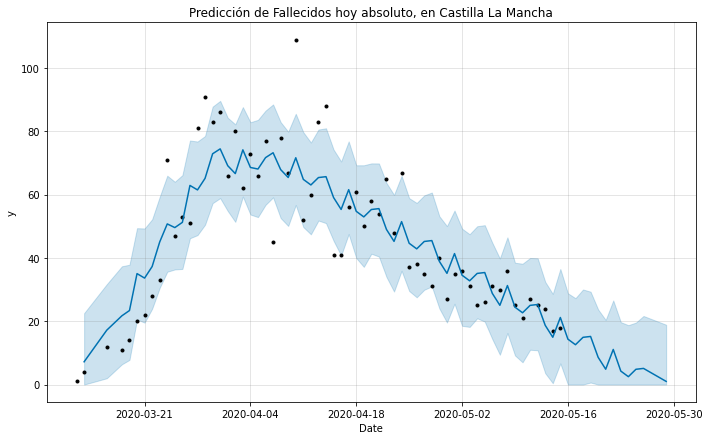

In [30]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Castilla La Mancha'
link="Prediccion_Fallecidos_hoy_absoluto_CM"

prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension , 
                                   link = link,                                   
                                   location  = COMUNIDAD_A_CONSIDERAR )
                                 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Las predicciones del total de Fallecidos hoy absoluto en Castilla La Mancha, cambian dia a dia
Predicción con los datos de 2020-05-15    1361.071759
Predicción con los datos de 2020-05-14    1368.391080
Predicción con los datos de 2020-05-13    1367.948372
Predicción con los datos de 2020-05-12    1346.347333
datos reales                              1244.000000
dtype: float64


,Predicción con los datos de 2020-05-15,Predicción con los datos de 2020-05-14,Predicción con los datos de 2020-05-13,Predicción con los datos de 2020-05-12,datos reales
ds,,,,,
2020-04-14,65.696483,65.734695,65.330143,66.133466,88.0
2020-04-15,59.110572,59.095046,58.862558,58.721567,41.0
2020-04-16,55.343747,55.369992,55.040272,55.391825,41.0
2020-04-17,61.589618,61.925917,61.824443,62.122817,56.0
2020-04-18,54.748611,54.794359,54.560267,54.978984,61.0
2020-04-19,52.984279,53.075904,52.747898,53.239354,50.0
2020-04-20,55.320579,55.442179,55.112898,55.568662,58.0
2020-04-21,55.599875,55.674594,55.384353,55.800596,54.0
2020-04-22,49.013004,49.034919,48.915743,48.387888,65.0


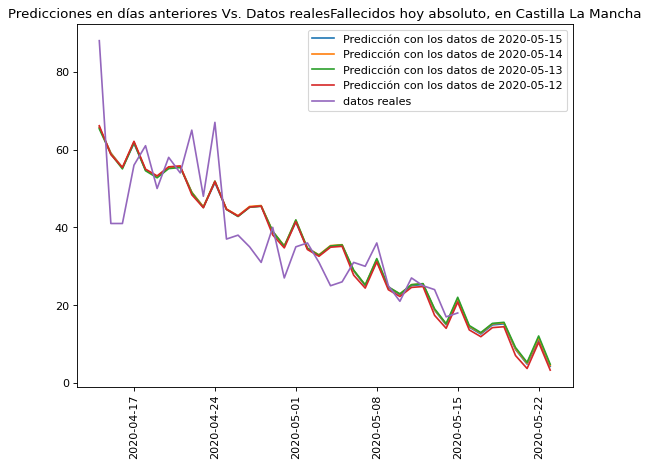

In [31]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Castilla La Mancha'
link="Prediccion_Compare_Fallecidos_hoy_absoluto_CM"

df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)
prediccion = Get_Predictions_Compare( df = df, 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR
                                   )
prediccion

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-21,10503.362662,1207.560906,17730.681369,10503.362662,10503.362662,-1130.119983,-1130.119983,-1130.119983,-1130.119983,-1130.119983,-1130.119983,0.0,0.0,0.0,9373.242679
1,2020-03-22,10618.530354,865.591519,17529.295672,10618.530354,10618.530354,-1662.947385,-1662.947385,-1662.947385,-1662.947385,-1662.947385,-1662.947385,0.0,0.0,0.0,8955.582969
2,2020-03-23,10733.698046,3338.839896,20729.772513,10733.698046,10733.698046,1996.519863,1996.519863,1996.519863,1996.519863,1996.519863,1996.519863,0.0,0.0,0.0,12730.217909
3,2020-03-24,10848.865738,3991.261603,20820.003983,10848.865738,10848.865738,1295.596574,1295.596574,1295.596574,1295.596574,1295.596574,1295.596574,0.0,0.0,0.0,12144.462312
4,2020-03-25,10964.033430,3015.575034,20298.897692,10964.033430,10964.033430,517.080455,517.080455,517.080455,517.080455,517.080455,517.080455,0.0,0.0,0.0,11481.113885
5,2020-03-26,11079.201122,2686.432472,19455.420697,11079.201122,11079.201122,-147.573321,-147.573321,-147.573321,-147.573321,-147.573321,-147.573321,0.0,0.0,0.0,10931.627801
6,2020-03-27,11194.368814,2113.572672,19193.878329,11194.368814,11194.368814,-868.556203,-868.556203,-868.556203,-868.556203,-868.556203,-868.556203,0.0,0.0,0.0,10325.812611
7,2020-03-28,11309.536505,1569.020348,18923.966881,11309.536505,11309.536505,-1130.119983,-1130.119983,-1130.119983,-1130.119983,-1130.119983,-1130.119983,0.0,0.0,0.0,10179.416522
8,2020-03-29,11424.704197,1324.189925,18383.991751,11424.704197,11424.704197,-1662.947385,-1662.947385,-1662.947385,-1662.947385,-1662.947385,-1662.947385,0.0,0.0,0.0,9761.756812
9,2020-03-30,11539.871889,5251.402369,21557.645574,11539.871889,11539.871889,1996.519863,1996.519863,1996.519863,1996.519863,1996.519863,1996.519863,0.0,0.0,0.0,13536.391753


Prediccion total para Hospitalizados : 4746132.7493966


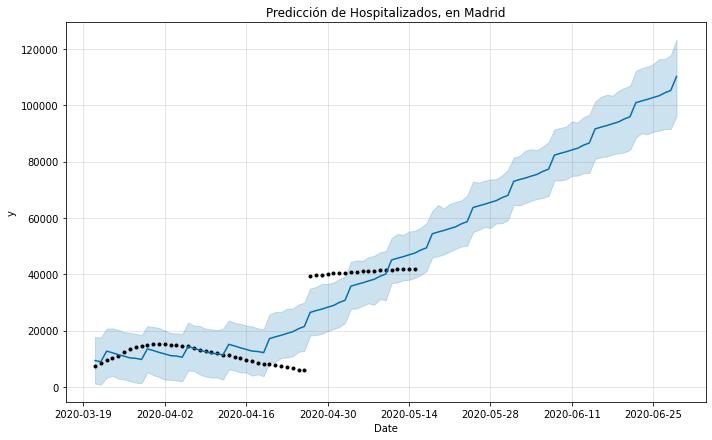

In [32]:
dimension = 'Hospitalizados'
COMUNIDAD_A_CONSIDERAR = 'Madrid'
link="Prediccion_Hospitalizados_Madrid"

prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension , 
                                   link = link,                                   
                                   location  = COMUNIDAD_A_CONSIDERAR )

,Proporcion Curados hoy absoluto / Casos hoy absoluto,Moving Average (4) Proporcion Curados hoy absoluto / Casos hoy absoluto
Fecha,,
2020-03-12,0.000000,NaN
2020-03-13,0.000000,NaN
2020-03-16,0.000000,NaN
2020-03-17,0.000000,0.000000
2020-03-18,0.000000,0.000000
2020-03-19,0.000000,0.000000
2020-03-20,0.000000,0.000000
2020-03-21,0.000000,0.000000
2020-03-22,0.000000,0.000000


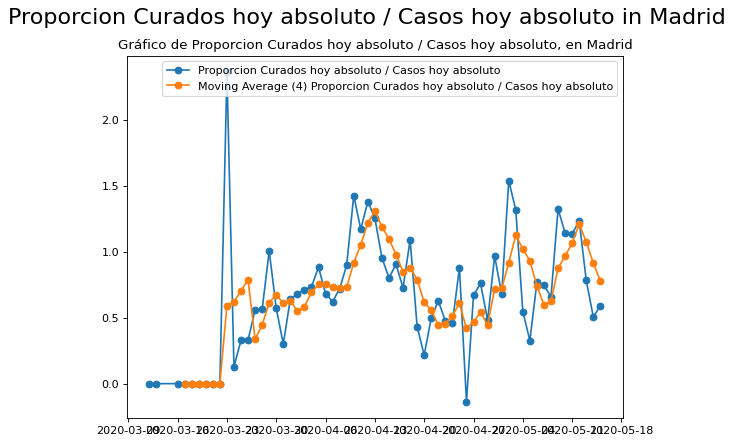

In [33]:
dimension = 'Proporcion Curados hoy absoluto / Casos hoy absoluto'
report_single_location_single_dimension('Madrid',dimension)


# ¿ Son reales estas cifras ? 
 
 Según reportaje de el mundo :https://www.elmundo.es/madrid/2020/04/07/5e8c427d21efa0b1668b45d6.html
 
   Entre los días 15 y 31 de marzo fallecieron en Madrid capital, "por todas las causas", aunque la mayoría por coronavirus, 5.950 personas, cuando en 2019, en el mismo lapso, murieron 1.100 personas

In [34]:
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

COMUNIDAD_A_CONSIDERAR = 'Madrid'
comunidad = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)

Insertar_Enlace("Reales")

comunidad.head(24).tail(15)['Fallecidos hoy absoluto'].sum()
comunidad['Fecha'] = comunidad.index

date1 = datetime.strptime('2020-03-15', '%Y-%m-%d')
date2 = datetime.strptime('2020-04-01', '%Y-%m-%d')

madrid_muertos_segun_sanidad = comunidad.loc[(comunidad['Fecha']>date1) & (comunidad['Fecha']<date2)]['Fallecidos hoy absoluto'].sum()

display(HTML ("Madrid muertos segun, <b>sanidad</b>, segunda quincena de Marzo:  <b>" + str(madrid_muertos_segun_sanidad)+"</b>"))

##

madrid_muertos_segun_interior = 5950 - 1100


display(HTML ("Madrid muertos segun, <b>interior</b>, mismo intervalo: <b>" + str(madrid_muertos_segun_interior)+"</b>"))


porcentaje_error = (madrid_muertos_segun_interior - madrid_muertos_segun_sanidad) / madrid_muertos_segun_sanidad


display(HTML ("La diferencia porcentual entre los muertos de sanidad e interior es de  <b>" + str(porcentaje_error) + "</b>") )

prediccion_muertos = comunidad['Fallecidos hoy absoluto'].sum()* (1+porcentaje_error)



display(HTML ("El numero de <b>fallecidos en Madrid</b>, hasta ahora es de <b>" + str(comunidad['Fallecidos hoy absoluto'].sum()) +
         "</b>, pero con el incremento del <b>" + str(porcentaje_error) +
         "</b> ,la cifra real sería de : <b>" + str(  int(prediccion_muertos)) + "</b> muertos" 
                                           ) )
Dimension = 'Fallecidos hoy absoluto'
df = Get_Dimension_CCAA(Dimension)

df['Total Fallecidos'] = df.sum(axis=1)

total_muertos_españa = int(df['Total Fallecidos'].sum())
prediccion_muertos_españa = total_muertos_españa* (1+porcentaje_error)

display(HTML ("El numero de <b>fallecidos en España</b>, hasta ahora es de <b>" + str(total_muertos_españa) +
         "</b>, pero con el incremento del <b>" + str(porcentaje_error) +
         "</b> ,la cifra real sería de : <b>" + str(  int(prediccion_muertos_españa)) + "</b> muertos"
                                           ))

In [35]:
from datetime import datetime

COMUNIDAD_A_CONSIDERAR = 'Madrid'
#comunidad = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)


comunidad.head(24).tail(15)['Fallecidos hoy absoluto'].sum()
comunidad['Fecha'] = comunidad.index

date1 = datetime.strptime('2020-03-15', '%Y-%m-%d')
date2 = datetime.strptime('2020-04-01', '%Y-%m-%d')

comunidad.loc[(comunidad['Fecha']>date1) & (comunidad['Fecha']<date2)]['Fallecidos hoy absoluto'].sum()

3522

Text(0.5, 1.0, 'Diferencia entre las cifras de muertos\n para Madrid y España\n entre los ministerios de Sanidad e Interior')

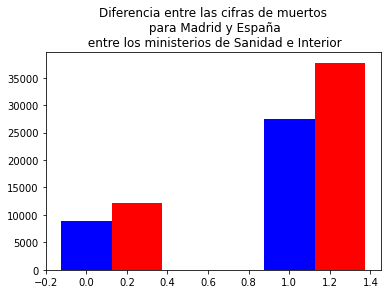

In [36]:
y = [comunidad['Fallecidos hoy absoluto'].sum(),total_muertos_españa]
z = [comunidad['Fallecidos hoy absoluto'].sum()* (1+porcentaje_error), total_muertos_españa* (1+porcentaje_error)]

X = np.arange(2)

ax=plt.subplot(111)
plt.bar(X+0, y,color = 'b', width = 0.25)
plt.bar(X+0.25, z,color = 'r', width = 0.25)


ax.set_title("Diferencia entre las cifras de muertos\n para Madrid y España\n entre los ministerios de Sanidad e Interior")
